In [2]:
import pandas as pd
from LLM_tags_predictor import ask_ollama, compute_jaccard, TAG_VOCAB
import pickle
from sklearn.metrics import jaccard_score, f1_score
from sklearn.preprocessing import MultiLabelBinarizer
from tqdm import tqdm
import time

2025-06-13 09:16:26.405 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-13 09:16:26.752 
  command:

    streamlit run c:\Users\mathi\miniconda3\envs\pytorch\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-06-13 09:16:26.753 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-13 09:16:26.754 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-13 09:16:26.754 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-13 09:16:26.755 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-13 09:16:26.755 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-13 09:16:26.756 Session s

In [4]:
data = pd.read_pickle('data/data_170125.pkl')
data = data.sample(150)

data.head()

,Id,Score,ViewCount,AnswerCount,CreationDate,clean_tags,cleaned_title_body,use_embedding
10803,69216269,0,451,1,2021-09-16 23:38:54,"[html, css]",how can i center text constantly in a responsi...,"[-0.06553246, -0.037537776, 0.03177514, 0.0242..."
14750,69325937,1,877,1,2021-09-25 11:59:31,[android],settheme does not work when using viewbinding ...,"[-0.08146609, -0.047046524, 0.054788604, 0.042..."
19113,69446599,0,801,1,2021-10-05 07:45:50,[python],flask upload to s3 using asyncio pi am trying ...,"[-0.044483162, -0.00086527807, 0.021490917, -0..."
47335,65686688,0,135,1,2021-01-12 15:12:48,"[javascript, node.js]",mongodb bson document size exception pi have c...,"[-0.0014033105, -0.058342915, 0.030866131, -0...."
9697,69186311,9,32094,3,2021-09-15 02:08:25,[python],python input function not working in vs code p...,"[-0.058933094, -0.07035302, 0.02363728, 0.0555..."


In [6]:
data.shape

(150, 8)

In [7]:

# Charger le MultiLabelBinarizer
mlb = pickle.load(open("mlb_use.pkl", "rb"))
TAG_VOCAB = mlb.classes_.tolist()

# Itérer sur le dataset et prédire les tags
predicted_tags_list = []
jaccard_scores = []
f1_scores = []

# Pour calculs finaux
all_y_true = []
all_y_pred = []

for idx, row in tqdm(data.iterrows(), total=len(data)):
    question = row['cleaned_title_body']
    true_tags = row['clean_tags']

    try:
        pred_tags = ask_ollama(question, TAG_VOCAB)
        predicted_tags_list.append(pred_tags)

        # Binariser les tags pour la ligne
        y_true_bin = mlb.transform([true_tags])
        y_pred_bin = mlb.transform([pred_tags])

        # Stocker pour calcul global
        all_y_true.append(y_true_bin[0])
        all_y_pred.append(y_pred_bin[0])

        # Jaccard score par question
        jaccard_scores.append(jaccard_score(y_true_bin, y_pred_bin, average='samples'))

        # F1 score par question
        f1_scores.append(f1_score(y_true_bin, y_pred_bin, average='samples', zero_division=0))

        time.sleep(1.5)  # éviter surcharge serveur Ollama
    except Exception as e:
        predicted_tags_list.append([])
        jaccard_scores.append(0.0)
        f1_scores.append(0.0)
        print(f"⚠️ Erreur à l’index {idx} : {e}")

# Ajouter les résultats au dataframe
data['predicted_tags'] = predicted_tags_list
data['jaccard_score'] = jaccard_scores
data['f1_score'] = f1_scores

c:\Users\mathi\miniconda3\envs\pytorch\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MultiLabelBinarizer from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
100%|██████████| 150/150 [1:06:23<00:00, 26.56s/it]


In [8]:
# Conversion en array pour calcul global
import numpy as np
y_true_array = np.array(all_y_true)
y_pred_array = np.array(all_y_pred)

# Moyennes globales
mean_jaccard = jaccard_score(y_true_array, y_pred_array, average='samples')
mean_f1 = f1_score(y_true_array, y_pred_array, average='samples', zero_division=0)

print(f"\n✅ Moyenne Jaccard score (échantillons) : {mean_jaccard:.4f}")
print(f"✅ Moyenne F1 score (échantillons) : {mean_f1:.4f}")


✅ Moyenne Jaccard score (échantillons) : 0.6234
✅ Moyenne F1 score (échantillons) : 0.7018


In [9]:
# Jaccard par tag
jaccard_by_tag = jaccard_score(y_true_array, y_pred_array, average=None)
jaccard_tag_df = pd.DataFrame({'tag': TAG_VOCAB, 'jaccard_score': jaccard_by_tag})
print("\n📊 Jaccard score par tag :")
print(jaccard_tag_df.sort_values(by='jaccard_score', ascending=False))


📊 Jaccard score par tag :
          tag  jaccard_score
8      python       0.888889
0     android       0.714286
9     reactjs       0.555556
2         css       0.500000
5  javascript       0.500000
3        html       0.480000
1      arrays       0.434783
4        java       0.414634
7      pandas       0.388889
6     node.js       0.375000


In [10]:
# F1 score par tag (à utiliser avec prudence si certains tags sont rares)
f1_by_tag = f1_score(y_true_array, y_pred_array, average=None, zero_division=0)
f1_tag_df = pd.DataFrame({'tag': TAG_VOCAB, 'f1_score': f1_by_tag})
print("\n📊 F1 score par tag (⚠️ sensible aux classes rares) :")
print(f1_tag_df.sort_values(by='f1_score', ascending=False))


📊 F1 score par tag (⚠️ sensible aux classes rares) :
          tag  f1_score
8      python  0.941176
0     android  0.833333
9     reactjs  0.714286
2         css  0.666667
5  javascript  0.666667
3        html  0.648649
1      arrays  0.606061
4        java  0.586207
7      pandas  0.560000
6     node.js  0.545455


In [11]:
pd.set_option('display.max_colwidth', 50)
data.head()

,Id,Score,ViewCount,AnswerCount,CreationDate,clean_tags,cleaned_title_body,use_embedding,predicted_tags,jaccard_score,f1_score
22937,69556704,-1,819,1,2021-10-13 13:44:16,[python],python replace part of the string inside of a...,"[-0.06165638, 0.019531753, 1.613379e-05, -0.01...","[python, arrays]",0.50,0.666667
31832,69811308,4,7466,2,2021-11-02 13:28:07,"[javascript, reactjs]",how to decode a url in javascript or nextjs pi...,"[-0.024228802, 0.02465344, 0.018727891, 0.0197...",[javascript],0.50,0.666667
13924,69303208,0,1608,1,2021-09-23 15:49:47,"[javascript, node.js]",how to properly inject provider in nestjs pi c...,"[0.021527542, -0.010595313, -0.030514885, -0.0...","[java, node.js, python]",0.25,0.400000
44045,65609229,0,29,1,2021-01-07 08:51:19,[python],pymongo throws replica set error in ubuntu pro...,"[-0.07009407, 0.031052276, -0.061096348, -0.05...",[python],1.00,1.000000
11709,69241730,0,97,1,2021-09-19 08:49:33,[node.js],publish app with js file changed in nodemodule...,"[-0.017439354, 0.038146514, -0.007821521, 0.00...","[javascript, node.js]",0.50,0.666667


In [12]:
# On change les options pandas pour afficher tout le texte
pd.set_option('display.max_colwidth', None)  # désactive le troncage des colonnes texte
jaccard_null = data.loc[(data['jaccard_score'] == 0) & (data['clean_tags'].apply(lambda tags: 'html' in tags)), ['cleaned_title_body', 'clean_tags']]
jaccard_null.head()

,cleaned_title_body,clean_tags
42102,in 2021 proper methods of ajax posting a form data coming from php pi have seen a number of methods dating back to about 2011 in order to take a form and have its data posted via ajaxjquery i have tried a couple and am just getting the page to reload despite using codepreventdefault functionscode from what i have read that tells em something with the jquery is not right but i am uncertain as to what i am trying to take data from my form have the jquery listen for the form submit by targeting the actual form id and then call a php function in order to have that data posted to the db ultimately nothing happens other than a page reloadp\npthe formp\nprecodeltform actionquotquot methodquotpostquot idquotajaxaddtoformquot autocompletequotoffquotgt\n ltinput typequottextquot idquotfnamequot namequotfnamequot placeholderquotfirst namequot valuequotquot requiredgt\n ltinput typequottextquot idquotlnamequot namequotlnamequot placeholderquotlast namequot valuequotquot requiredgt\n ltselect idquotsizequot requiredgt\n ltoption valuequotquotgtsizeltoptiongt\n ltphp fori1 ilt15 i++gt\n ltoption valuequotltphp echo i gtquotgtltphp echo i gtltoptiongt\n ltphp gt\n ltselectgt\n ltinput typequottextquot idquotmobilenumberquot namequotmobilenumberquot placeholderquotphone numberquot valuequotquot requiredgt\n ltinput typequotemailquot idquotcustomer_emailquot namequotcustomer_emailquot placeholderquotemail addressquot valuequotquot requiredgt\n ltinput typequotsubmitquot namequotajaxaddtoformquot valuequotadd toquotgt\nltformgt\nthe jquery\n\n jquerydocumentready function\n jquery#ajaxaddtoformonsubmit functione\nepreventdefault\n jquery#jxloadingshow\n jqueryajax\n type post\n url my_ajaxajax_url\n data \n action ajaxphpfunction\n success functiondata\n jquery#jxloadinghide\n \n \n \n \n \n return false \n \ncodepre\npthe phpp\nprecodefunction ajaxphpfunction \n global wpdb \n table quotmytablenamequot \n fname _postfname \n lname _postlname \n mobilenumber _postmobilenumber \n email _postemail \n data array\n fname gt fname\n lname gt lname \n mobilenumber gt mobilenumber \n email gt email \n success wpdbgtinsert table data \n ifsuccess\n echo json_encodelast_data \n else echo error die \n \ncodepre\n,[html]
25429,angular 11 increment index value in html pi have a variable in my ts that contains a value of 3 array length i want to use it in my html to increment the value of index 0 until the value of 3 is reachedp\nprecodelttable mattable datasourcequotdatasourcequizoverviewquot matsortgt\n ltngcontainer matcolumndefquotquestion_textquotgt\n ltth classquotfontquot matheadercell matheadercelldef matsortheadergtquestionsltthgt\n lttd classquotfontquot matcell matcelldefquotlet rowquotgtrowquiz_records0question_textlttdgt\n ltngcontainergt\n \n ltngcontainer matcolumndefquotuser_answersquotgt\n ltth classquotfontquot matheadercell matheadercelldef matsortheadergtanswerltthgt\n lttd classquotfontquot matcell matcelldefquotlet rowquotgtrowquiz_records0user_answerslttdgt\n ltngcontainergt\nlttablegt\ncodepre\nptsp\nprecode quiz_recordslengthlength number 3\ncodepre\n,"[html, arrays]"
44235,how can i refer to an r code chunk on a different page using r markdown reproducible example provided in the text plets say i have an r markdown pdf document that have 2 pagesp\nprecode# page 1\nr code that was used to perform the regression analysis can be found by clicking here\ncodepre\npwhat i want is when i click on quotherequot it referstakes me to the code in the page two suppose the page 2 contains the following codep\nprecode# page 2\nmodel lmyx data data\ncodepre\npany ideasp\n,[html]


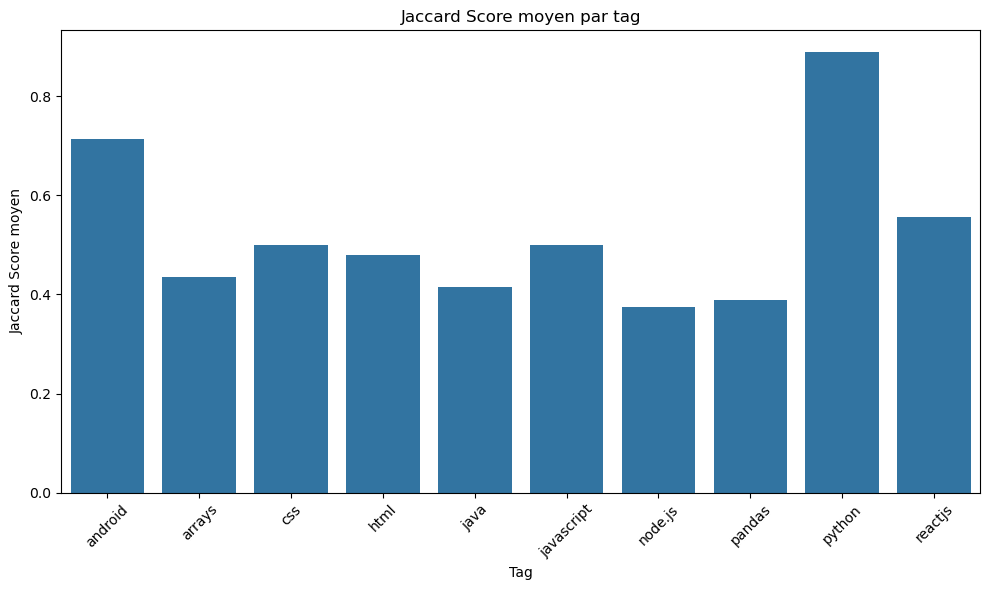

In [13]:
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt


# Tracé du barplot
plt.figure(figsize=(10, 6))
sns.barplot(data=jaccard_tag_df, x='tag', y='jaccard_score')
plt.title("Jaccard Score moyen par tag")
plt.xlabel("Tag")
plt.ylabel("Jaccard Score moyen")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
# Sauvegarde des résultats
data.to_pickle("data/results_llm_tags_codestral_22b.pkl")

In [3]:
pd.set_option('display.max_colwidth', None)
base = pd.read_pickle('data/data_170125.pkl')

In [4]:
id = [69860469, 69178825, 68921155, 69263131, 70026530, 69216946, 65584827, 69428650, 69737336, 69337477, 69882740, 69084987, 69357560, 69336061, 69291016]
human_base = base[base['Id'].isin(id)]
pred_tags = {
    69860469: ['java'],
    69178825: ['python'],
    68921155: ['html'],
    69263131: ['python', 'pandas'],
    70026530: ['python'],
    69216946: ['reactjs', 'html'],
    65584827: ['javascript'],
    69428650: ['arrays'],
    69737336: ['python', 'arrays'],
    69337477: ['python', 'arrays'],
    69882740: ['javascript'],
    69084987: ['android'],
    69357560: ['python'],
    69336061: ['javascript'],
    69291016: ['arrays'],
}
human_base['predicted_tags'] = human_base['Id'].map(pred_tags)

C:\Users\mathi\AppData\Local\Temp\ipykernel_19352\1081301645.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  human_base['predicted_tags'] = human_base['Id'].map(pred_tags)


In [5]:

# Fonction de Jaccard Score
def jaccard_score(set1, set2):
    set1, set2 = set(set1), set(set2)
    if not set1 and not set2:
        return 1.0
    return len(set1 & set2) / len(set1 | set2)

def f1_score(true_tags, pred_tags):
    true_set, pred_set = set(true_tags), set(pred_tags)
    tp = len(true_set & pred_set)
    if not pred_set and not true_set:
        return 1.0
    if not pred_set or not true_set:
        return 0.0
    precision = tp / len(pred_set)
    recall = tp / len(true_set)
    if precision + recall == 0:
        return 0.0
    return 2 * precision * recall / (precision + recall)

# Calcul du Jaccard entre les vraies tags et les prédictions manuelles
# Assumer que la colonne avec les vrais tags s'appelle 'Tags' et contient des listes
human_base['jaccard_score'] = human_base.apply(
    lambda row: jaccard_score(row['clean_tags'], row['predicted_tags']),
    axis=1
)

# F1 score par question
human_base['f1_score'] = human_base.apply(
    lambda row: f1_score(row['clean_tags'], row['predicted_tags']), axis=1
)

C:\Users\mathi\AppData\Local\Temp\ipykernel_19352\3672641030.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  human_base['jaccard_score'] = human_base.apply(
C:\Users\mathi\AppData\Local\Temp\ipykernel_19352\3672641030.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  human_base['f1_score'] = human_base.apply(


In [6]:
pd.set_option('display.max_colwidth', 50)
human_base

,Id,Score,ViewCount,AnswerCount,CreationDate,clean_tags,cleaned_title_body,use_embedding,predicted_tags,jaccard_score,f1_score
33553,69860469,1,1237,1,2021-11-06 00:07:26,[java],profile specific logging in spring boot pwe ha...,"[-0.04296598, -0.007560627, -0.0602761, -0.006...",[java],1.000000,1.000000
9427,69178825,0,770,1,2021-09-14 13:35:22,[python],merge a set of pointssmall contours into a big...,"[-0.06454741, -0.06673579, 0.040491477, -0.056...",[python],1.000000,1.000000
199,68921155,2,974,4,2021-08-25 10:27:06,"[javascript, html, css]",select a td by table class pive searched onlin...,"[0.040511478, -0.067848295, 0.0467658, 0.06671...",[html],0.333333,0.500000
12447,69263131,0,31,1,2021-09-21 03:44:43,"[python, pandas]",how to sum dataframe column sections up to a t...,"[-0.06336666, -0.06664925, 0.032806825, -0.001...","[python, pandas]",1.000000,1.000000
39489,70026530,1,1225,1,2021-11-18 20:44:54,[python],opencv python remove small points noise in bi...,"[-0.06772037, -0.051268514, 0.051491614, -0.00...",[python],1.000000,1.000000
10822,69216946,0,70,1,2021-09-17 01:58:34,"[html, reactjs]",react dynamic template with form control auto...,"[0.03470259, -0.02302494, 0.04138034, -0.02461...","[reactjs, html]",1.000000,1.000000
43106,65584827,0,713,1,2021-01-05 18:49:28,"[javascript, html, css]",composer require dompdfdompdf not install bloc...,"[-0.06277866, -0.045572627, -0.020939609, -0.0...",[javascript],0.333333,0.500000
18471,69428650,1,595,2,2021-10-03 20:29:52,[arrays],multiple processes driving an array of records...,"[-0.05384037, -0.06437662, 0.008059723, 0.0095...",[arrays],1.000000,1.000000
29282,69737336,0,1411,1,2021-10-27 10:53:20,[python],how to speed up a python function with numba p...,"[-0.053408414, -0.06998594, 0.0047623035, 0.00...","[python, arrays]",0.500000,0.666667
15177,69337477,1,678,1,2021-09-26 17:53:21,"[python, arrays]",efficient way to fill a 1d numpy array of vari...,"[-0.043191645, -0.06822634, 0.064459935, -0.00...","[python, arrays]",1.000000,1.000000


In [7]:
# Sauvegarde des résultats
human_base.to_pickle("data/results_human_pred.pkl")

In [8]:
chat_gpt = base[base['Id'].isin(id)]
pred_tags = {
    69860469: ['java'],
    69178825: ['python', 'arrays'],
    68921155: ['html', 'css', 'javascript'],
    69263131: ['python', 'pandas'],
    70026530: ['python'],
    69216946: ['reactjs', 'html'],
    65584827: ['arrays'],
    69428650: ['arrays'],
    69737336: ['python', 'pandas'],
    69337477: ['python', 'arrays', 'pandas'],
    69882740: ['javascript', 'node.js', 'reactjs'],
    69084987: ['java'],
    69357560: ['python', 'pandas'],
    69336061: ['python', 'javascript'],
    69291016: ['javascript', 'arrays'],
}
chat_gpt['predicted_tags'] = chat_gpt['Id'].map(pred_tags)
# Calcul du Jaccard entre les vraies tags et les prédictions manuelles
# Assumer que la colonne avec les vrais tags s'appelle 'Tags' et contient des listes
chat_gpt['jaccard_score'] = chat_gpt.apply(
    lambda row: jaccard_score(row['clean_tags'], row['predicted_tags']),
    axis=1
)

# F1 score par question
chat_gpt['f1_score'] = chat_gpt.apply(
    lambda row: f1_score(row['clean_tags'], row['predicted_tags']), axis=1
)

C:\Users\mathi\AppData\Local\Temp\ipykernel_19352\3825695729.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chat_gpt['predicted_tags'] = chat_gpt['Id'].map(pred_tags)
C:\Users\mathi\AppData\Local\Temp\ipykernel_19352\3825695729.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chat_gpt['jaccard_score'] = chat_gpt.apply(
C:\Users\mathi\AppData\Local\Temp\ipykernel_19352\3825695729.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [9]:
chat_gpt

,Id,Score,ViewCount,AnswerCount,CreationDate,clean_tags,cleaned_title_body,use_embedding,predicted_tags,jaccard_score,f1_score
33553,69860469,1,1237,1,2021-11-06 00:07:26,[java],profile specific logging in spring boot pwe ha...,"[-0.04296598, -0.007560627, -0.0602761, -0.006...",[java],1.000000,1.000000
9427,69178825,0,770,1,2021-09-14 13:35:22,[python],merge a set of pointssmall contours into a big...,"[-0.06454741, -0.06673579, 0.040491477, -0.056...","[python, arrays]",0.500000,0.666667
199,68921155,2,974,4,2021-08-25 10:27:06,"[javascript, html, css]",select a td by table class pive searched onlin...,"[0.040511478, -0.067848295, 0.0467658, 0.06671...","[html, css, javascript]",1.000000,1.000000
12447,69263131,0,31,1,2021-09-21 03:44:43,"[python, pandas]",how to sum dataframe column sections up to a t...,"[-0.06336666, -0.06664925, 0.032806825, -0.001...","[python, pandas]",1.000000,1.000000
39489,70026530,1,1225,1,2021-11-18 20:44:54,[python],opencv python remove small points noise in bi...,"[-0.06772037, -0.051268514, 0.051491614, -0.00...",[python],1.000000,1.000000
10822,69216946,0,70,1,2021-09-17 01:58:34,"[html, reactjs]",react dynamic template with form control auto...,"[0.03470259, -0.02302494, 0.04138034, -0.02461...","[reactjs, html]",1.000000,1.000000
43106,65584827,0,713,1,2021-01-05 18:49:28,"[javascript, html, css]",composer require dompdfdompdf not install bloc...,"[-0.06277866, -0.045572627, -0.020939609, -0.0...",[arrays],0.000000,0.000000
18471,69428650,1,595,2,2021-10-03 20:29:52,[arrays],multiple processes driving an array of records...,"[-0.05384037, -0.06437662, 0.008059723, 0.0095...",[arrays],1.000000,1.000000
29282,69737336,0,1411,1,2021-10-27 10:53:20,[python],how to speed up a python function with numba p...,"[-0.053408414, -0.06998594, 0.0047623035, 0.00...","[python, pandas]",0.500000,0.666667
15177,69337477,1,678,1,2021-09-26 17:53:21,"[python, arrays]",efficient way to fill a 1d numpy array of vari...,"[-0.043191645, -0.06822634, 0.064459935, -0.00...","[python, arrays, pandas]",0.666667,0.800000


In [10]:
# Sauvegarde des résultats
chat_gpt.to_pickle("data/results_chatgpt_pred.pkl")

In [11]:
import pandas as pd

# Chargement des résultats
mistral_mini = pd.read_pickle('data/results_llm_tags_mistralmini_24b.pkl')
mistral = pd.read_pickle('data/results_llm_tags_mistral7b.pkl')
deepseek = pd.read_pickle('data/results_llm_tags_deepseek14b.pkl')
llama = pd.read_pickle('data/results_llm_tags_llama3_8b.pkl')
codestral = pd.read_pickle('data/results_llm_tags_codestral_22b.pkl')
human_base = pd.read_pickle('data/results_human_pred.pkl')
chat_gpt = pd.read_pickle('data/results_chatgpt_pred.pkl')

In [12]:
# Calcul des moyennes
results = {
    'mistral_mini': {
        'jaccard_score': mistral_mini['jaccard_score'].mean(),
        'f1_score': mistral_mini['f1_score'].mean()
    },
    'mistral': {
        'jaccard_score': mistral['jaccard_score'].mean(),
        'f1_score': mistral['f1_score'].mean()
    },
    'deepseek': {
        'jaccard_score': deepseek['jaccard_score'].mean(),
        'f1_score': deepseek['f1_score'].mean()
    },
    'llama': {
        'jaccard_score': llama['jaccard_score'].mean(),
        'f1_score': llama['f1_score'].mean()
    },
    'Codestral': {
        'jaccard_score': codestral['jaccard_score'].mean(),
        'f1_score': codestral['f1_score'].mean()
    },
    'Baseline': {
        'jaccard_score': '0.634028',
        'f1_score': '0.673697'
    },
    'Human_base': {
        'jaccard_score': human_base['jaccard_score'].mean(),
        'f1_score': human_base['f1_score'].mean()
    },
    'ChatGPT': {
        'jaccard_score': chat_gpt['jaccard_score'].mean(),
        'f1_score': chat_gpt['f1_score'].mean()
    }
}

# Construction du DataFrame
df_scores = pd.DataFrame.from_dict(results, orient='index').reset_index()
df_scores.columns = ['model', 'jaccard_score', 'f1_score']

print(df_scores)

          model jaccard_score  f1_score
0  mistral_mini      0.630556  0.724889
1       mistral      0.614889  0.670698
2      deepseek      0.649667   0.71446
3         llama      0.635444  0.700275
4     Codestral      0.623444   0.70181
5      Baseline      0.634028  0.673697
6    Human_base      0.744444       0.8
7       ChatGPT      0.766667      0.82
